# Numerics 1: Homework 02

## Cooper Simpson

## Setup

In [ ]:
#Theme
from jupyterthemes import jtplot
!jt -t grade3
jtplot.style()

In [ ]:
!jt -r;

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.integrate as spi
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
#Defining our integration and differentation functions

#Differentation: central for interior points fwd/bkwd for ends
def diff(x, f):
    df = np.zeros(len(f))
    h = x[1] - x[0]
    
    #First
    df[0] = (f[1]-f[0])/h
    
    #Interior
    for i in range(1,len(f)-1):
        df[i] = (f[i+1]-f[i-1])/(2*h)
    
    #Last
    df[-1] = (f[-1]-f[-2])/h
    
    return df

#Trapezoidal integration
def trapezoidal(f, a, b, h=0.1):
    pts = np.arange(a,b+h,h)
    y = f(pts)
    y[1:-1] *= 2
    
    return (h/2)*np.sum(y)

#Simpson's 1/3 integration
def simpson_13(f, a, b, h=0.1):
    pts = np.arange(a,b+h,h)
    y = f(pts)
    for i in range(1,len(y)-1):
        if i%2==0:
            y[i] *= 2
        else:
            y[i] *= 4
            
    return (h/3)*np.sum(y)


#Legendre polynomial roots (i.e. eval locations)
gqLoc = {2:np.array([-np.sqrt(3)/3, np.sqrt(3)/3]), 
            3:np.array([-np.sqrt(15)/5, 0, np.sqrt(15)/5])}
gqCoeff = {2:np.array([1,1]), 
            3:np.array([5/9, 8/9, 5/9])}

#Gaussian Quadrature integration
def gaussQuad(f, a, b, n):
    #Need to convert to [-1,1]
    factor = (b-a)/2
    def transform(x):
        return (x*(b-a)+a+b)/2
    
    #Using lookup table
    t = transform(gqLoc[n])
    c = gqCoeff[n]
    
    I = factor*(np.dot(c,f(t)))
        
    return I

## Problem 1
We apply the difference formulas for numerical differentation.

Using the following table we wish to compute the associated derivative at each point. We have done this with a program that uses the forward difference method for the left endpoint, backward difference for the right endpoint, and central difference for interior points.

In [4]:
#Define our given data
data = {'x':[0.5,0.6,0.7], 'f(x)':[0.4794,0.5646,0.6442]}
tab = pd.DataFrame(data)
display(tab)

,x,f(x)
0,0.5,0.4794
1,0.6,0.5646
2,0.7,0.6442


In [5]:
#Calculate the derivative
df = diff(tab.loc[:,'x'].values, tab.loc[:,'f(x)'].values)
tab["f'(x)"] = df
tab['numpy'] = np.gradient(tab.loc[:,'f(x)'].values, 0.1)
display(tab)

,x,f(x),f'(x),numpy
0,0.5,0.4794,0.852,0.852
1,0.6,0.5646,0.824,0.824
2,0.7,0.6442,0.796,0.796


We can see above that we have filled in our table with two additional columns. The first is "f'(x)" which is the derivative computed with our program written above. The second is the derivative computed with numpy's *gradient* function -- serving just to validate our answer.

## Problem 2
Using Taylor series expansions we arrive at a forward weighted sum formula for numerical differentation.

We wish to arrive at the expression:

$$ f'(x)\approx \frac{1}{h}(-\frac{3}{2}f(x) + 2f(x+h) - \frac{1}{2}f(x+2h)) $$

We begin by writing our derivative as a weighted sum of function values with unknown coefficients.

$$ f'(x) = af(x) + bf(x+h) + cf(x+2h) $$

We will then expand everything on the right hand side as Taylor series centered at x. Doing this gives the following results for all the terms:

$$
\begin{align}
    &af(x) = af(x)\\
    &bf(x+h) = b[f(x) + hf'(x) + \frac{h^2}{2}f''(x) + \cdots]\\
    &xf(x+2h) = x[f(x) + 2hf'(x) + 2h^2f''(x) + \cdots]
\end{align}
$$

Next, we match coefficients from the left and right hand sides to determine the values for a, b, and c. We note that we only expanded to three terms as we will only need three equations to determine our weighting. If we were interested in the error we could expand further, but we will not do so here.

$$
\begin{align}
    &f(x)\implies 0=a+b+c\\
    &f'(x)\implies 1=bh+2hc\\
    &f''(x)\implies 0 = \frac{bh^2}{2} + 2ch^2
\end{align}
$$

The second equation implies that $b=\frac{1}{h}+2c$, and together with the third equation this implies that $0 = \frac{h}{2}+ch^2$. This gives us $c=\frac{-1}{2h}$ and $b=\frac{2}{h}$. Plugging both of these into the first equation gives $a=\frac{-3}{2h}$. Having determined all of our coefficients we arrive at our final answer:

$$
\boxed{f'(x)\approx \frac{-3}{2h}f(x) + \frac{2}{h}f(x+h) + \frac{-1}{2h}f(x+2h)}
$$

## Problem 3
We derive Simpson's $\frac{3}{8}$ rule using Lagrange polynomials as well as Taylor comparison.

We will first define a few things that will be necessary for both methods moving forward. Simpson's 3/8 rule is a method for numerically evaluating -- using four sample points -- an integral of the form:

$$ \int_a^bf(x)\;dx $$

We will take four sample points inside $[a,b]$ with $x_i=a+ih,\;i=0,1,2,3,\;h=\frac{b-a}{3}$. We note that in practice if the region of integration was large than this method would be done repeatedly for smaller slices inside the region (i.e composite Simpson's). With this setup Simpson's 3/8 rule is given as follows:

$$ \int_{x_0}^{x_3}f(x)\;dx\approx\frac{3h}{8}[f(x_0)+3f(x_1)+3f(x_2)+f(x_3)] $$

### a). Lagrange
We want to build a third degree Lagrange polynomial that passes through all four of our points and integrate that as an approximation of the true integral. Letting $L(x)$ be our third degree Lagrange polynomial we will say the following:

$$ \int_a^bf(x)\;dx=\int_{x_0}^{x_3}f(x)\;dx\approx\int_{x_0}^{x_3}L(x)\;dx $$

Our first step is to build the Lagrange polynomial, this is rather straightforward and gives us the following:

$$
\begin{align}
    L(x) &=\frac{(x-x_1)(x-x_2)(x-x_3)}{(x_0-x_1)(x_0-x_2)(x_0-x_3)}f(x_0)\\
    &+\frac{(x-x_0)(x-x_2)(x-x_3)}{(x_1-x_0)(x_1-x_2)(x_0-x_3)}f(x_1)\\
    &+\frac{(x-x_0)(x-x_1)(x-x_3)}{(x_2-x_0)(x_2-x_1)(x_2-x_3)}f(x_2)\\
    &+\frac{(x-x_0)(x-x_1)(x-x_2)}{(x_3-x_0)(x_3-x_1)(x_3-x_2)}f(x_3)
\end{align}
$$

Next, we will make a change of variables that will simplify the integral to a large degree, so we let $s=\frac{2x-x_0-x_3}{x_3-x_0}$. Plugging in our integration bounds we see that $x=x_0\implies s=-1$ and $x=x_3\implies s=1$. Differentiating we see that $ds=\frac{2}{3h}dx$, so the last step is to determine the numerator values for our polynomials. We first write $x=\frac{3hs+2x_0+3h}{2}$ and then proceed as follow:

$$
\begin{align}
    &x-x_0=\frac{3hs+3h}{2}=\frac{h}{2}(3s+3)\\
    &x-x_1=\frac{3hs+h}{2}=\frac{h}{2}(3s+1)\\
    &x-x_2=\frac{3hs-h}{2}=\frac{h}{2}(3s-1)\\
    &x-x_3=\frac{3hs-3h}{2}=\frac{h}{2}(3s-3)
\end{align}
$$

One further step remains before we can integrate, we must evaluate the denomenator of all terms in our Lagrange polynomial.

$$
\begin{align}
    &(x_0-x_1)(x_0-x_2)(x_0-x_3)=(-h)(-2h)(-3h)=-6h^3\\
    &(x_1-x_0)(x_1-x_2)(x_0-x_3)=(h)(-h)(-2h)=2h^3\\
    &(x_2-x_0)(x_2-x_1)(x_2-x_3)=(2h)(h)(-h)=-2h^3\\
    &(x_3-x_0)(x_3-x_1)(x_3-x_2)=(3h)(2h)(h)=6h^3
\end{align}
$$

Putting this all back together we have our final integral that we must evaluate.

$$
\begin{align}
    \int_{-1}^1 &\frac{h^3}{8}[\frac{(3s+1)(3s-1)(3s-3)}{-6h^3}f(x_0)\\
    &+\frac{(3s+3)(3s-1)(3s-3)}{2h^3}f(x_1)\\
    &+\frac{(3s+3)(3s+1)(3s-3)}{-2h^3}f(x_2)\\
    &+\frac{(3s+3)(3s+1)(3s-1)}{6h^3}f(x_3)]\frac{3h}{2}ds
\end{align}
$$

Simplifying this we get...

$$
\begin{align}
    \frac{3h}{32}\int_{-1}^1 &\frac{(3s+1)(3s-1)(3s-3)}{-3}f(x_0)\\
    &+(3s+3)(3s-1)(3s-3)f(x_1)\\
    &-(3s+3)(3s+1)(3s-3)f(x_2)\\
    &+\frac{(3s+3)(3s+1)(3s-1)}{3}f(x_3)ds
\end{align}
$$

The final step is to integrate which we will do individually for each term.

$$
\begin{align}
    &\int_{-1}^1 \frac{(3s+1)(3s-1)(3s-3)}{-3}f(x_0)ds\\
    &=\frac{-f(x_0}{3}\int_{-1}^1 27s^3-27s^2-3s+3=-12\frac{-f(x_0}{3}=4f(x_0)
\end{align}
$$

---

$$
\begin{align}
    &\int_{-1}^1 (3s+3)(3s-1)(3s-3)f(x_1)ds\\
    &=f(x_1)\int_{-1}^1 27s^3-9s^2-27s+9=12f(x_1)=(4)(3)f(x_1)
\end{align}
$$

---

$$
\begin{align}
    &\int_{-1}^1 -(3s+3)(3s+1)(3s-3)f(x_2)ds\\
    &=-f(x_2)\int_{-1}^1 27s^3+9s^2-27s-9=12f(x_2)=(4)(3)f(x_2)
\end{align}
$$

---

$$
\begin{align}
    &\int_{-1}^1 \frac{(3s+3)(3s+1)(3s-1)}{3}f(x_3)ds\\
    &=\frac{f(x_3)}{3}\int_{-1}^1 27s^3+27s^2-3s-3=12\frac{f(x_3)}{3}=4f(x_3)
\end{align}
$$

Factoring the $4$ out of all of these values, and remembering to multiply by the original factor of $\frac{3h}{32}$ we have finally arrived at our Simpson's 3/8 expression.

$$ \int_a^bf(x)\;dx=\int_{x_0}^{x_3}f(x)\;dx\approx\frac{3h}{8}[f(x_0)+3f(x_1)+3f(x_2)+f(x_3)] $$

### b). Taylor
We would like to write our integral as the weighted sum of our function evaluated at our sample points.

$$ \int_a^bf(x)\;dx=\int_{x_0}^{x_3}f(x)\;dx\approx af(x_0)+bf(x_1)+cf(x_2)+df(x_3) $$

We will expand $f(x)$ as a Taylor polynomial centered around our first point $x_0$. We also note that we only expand to the first four terms as we will only need four equations to solve for our coefficients. More terms could be used to identify the error, but this will not be done here.

$$ \text{Taylor}\implies f(x)=f(x_0)+(x-x_0)f'(x_0)+\frac{(x-x_0)^2}{2}f''(x)+\frac{(x-x_0)^3}{6}f'''(x)+\cdots $$

Plugging this in on the left hand side gives us the following expression for the integral:

$$ 
\begin{align}
    \int_{x_0}^{x_3}f(x)\;dx&=\int_{x_0}^{x_3}f(x_0)+(x-x_0)f'(x_0)+\frac{(x-x_0)^2}{2}f''(x)+\frac{(x-x_0)^3}{6}f'''(x)+\cdots\\
    &=xf(x_0)+\frac{(x-x_0)^2}{2}f'(x_0)+\frac{(x-x_0)^3}{6}f''(x)+\frac{(x-x_0)^4}{24}f'''(x)+\cdots\bigg|_{x_0}^{x_3}\\
    &=3hf(x_0)+\frac{9h^2}{2}f'(x_0)+\frac{9h^3}{2}f''(x_0)+\frac{27h^4}{8}f'''(x_0)+\cdots
\end{align}
$$

Plugging our expansion into the right hand side gives us the following:

$$
\begin{align}
    af(x_0)+bf(x_1)+cf(x_2)+df(x_3)&=af(x_0)\\
    &+b[f(x_0)+hf'(x_0)+\frac{h^2}{2}f''(x_0)+\frac{h^3}{6}f'''(x_0)+\cdots]\\
    &+c[f(x_0)+2hf'(x_0)+2h^2f''(x_0)+\frac{4h^3}{3}f'''(x_0)+\cdots]\\
    &+d[f(x_0)+3hf'(x_0)+\frac{9h^2}{2}f''(x_0)+\frac{9h^3}{2}f'''(x_0)+\cdots]
\end{align}
$$

Our next step is to match coefficients for the various derivatives of the function $f(x)$.

$$
\begin{align}
    &f(x):\;\; 3h=a+b+c+d\\
    &f'(x):\;\; \frac{9h^2}{2}=bh+2ch+3dh\\
    &f''(x):\;\; \frac{9h^3}{2}=\frac{bh^2}{2}+2ch^2+\frac{9dh^2}{2}\\
    &f'''(x):\;\; \frac{27h^4}{8}=\frac{bh^3}{6}+\frac{4ch^3}{3}+\frac{9dh^3}{2}
\end{align}
$$

We can see that we have four equations and four unknowns so all we need to do is solve the linear system. We note that every equation will have an $h$ on the left hand side telling us there will be an $h$ in the final value for each coefficient. We will use Numpy's linear system solver to determine our coefficients.

In [6]:
A = np.array([[1,1,1,1],
            [0,1,2,3],
            [0,1/2,2,9/2],
            [0,1/6,4/3,9/2]])

b = np.array([3,9/2,9/2,27/8])
b.reshape((len(b),1))

x = np.linalg.solve(A,b)
display(x)

array([0.375, 1.125, 1.125, 0.375])

As can be seen above our coefficients have the following values: $\boxed{a=\frac{3h}{8},\;b=\frac{9h}{8},\;c=\frac{9h}{8},\;d=\frac{3h}{8}}$. We note that the $h$ was factored out of $\bf{b}$ to use the numerical solver. As is easy to see this does in fact give us Simpson's 3/8 rule.

$$ \int_a^bf(x)\;dx=\int_{x_0}^{x_3}f(x)\;dx\approx\frac{3h}{8}[f(x_0)+3f(x_1)+3f(x_2)+f(x_3)] $$

## Problem 4
We use the composite trapezoidal rule and the composite Simpson's $\frac{1}{3}$ rule to numerically integrate.

We wish to compute the integral $I=\int_0^2x^2e^{-x^2}dx$ using the following methods with $h=0.25$. This integral is not something that we can compute analytically, so we are unable to compare to the "actual" value. Below we have set up our function and plotted it for visualization purposes. We also note that our integration functions have been defined above.

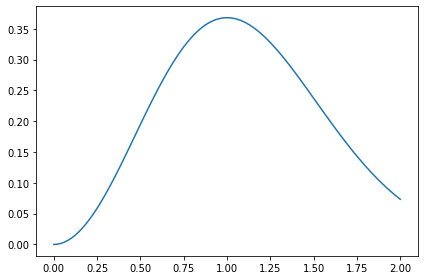

In [7]:
a = 0
b = 2
h = 0.25
def f(x):
    return (x**2)*(np.exp(-x**2))

x = np.linspace(0,2,100)

plt.plot(x, f(x))
plt.tight_layout()

### a).
Here we use the composite Trapezoidal rule.

In [8]:
coop = trapezoidal(f, a, b, h)
x = np.arange(0,2+h,h)
real = np.trapz(f(x), x)

print('I=%f, Numpy=%f' % (coop, real))

I=0.421582, Numpy=0.421582


We can see that our composite trapezoidal function evaluated the integral as $\boxed{I=0.421582}$. Note that the *Numpy* value is just being used for verification.

### b). 
Here we use the composite Simpson's $\frac{1}{3}$ rule.

In [9]:
coop = simpson_13(f, a, b, h)
x = np.arange(0,2+h,h)
real = spi.simps(f(x), x)

print('I=%f, Scipy=%f' % (coop, real))

I=0.422716, Scipy=0.422716


We can see that our composite Simpson's 1/3 function evaluated the integral as $\boxed{I=0.422716}$. Note that the *Scipy* value is just being used for verification.

## Problem 5
We use Gaussian quadrature to numerically compute an integral for different degrees $n$.

We wish to compute the integral $I=\int_0^1x^2e^{-x}dx$ using the following number of terms in the weighted sum. 

First we wish to compute the integral analytically to have something to compare it to.

We will need to integrate by parts twice, so letting $u=x^2$, $du=2xdx$, $dv=e^{-x}dx$, $v=-e^{-x}$ we have:

$$
\int_0^1x^2e^{-x}dx = -x^2e^{-x}\big|_0^1 + \int_0^12xe^{-x}dx
$$

Our substitutions remain the same and so we have:

$$
\int_0^12xe^{-x}dx = 2[-xe^{-x}\big|_0^1+\int_0^1e^{-x}]
$$

Giving us the final expression:

$$
\int_0^1x^2e^{-x}dx = -x^2e^{-x}\big|_0^1 -2xe^{-x}\big|_0^1 -2e^{-x}\big|_0^1 = \boxed{2 - 5e^{-1}=I}
$$

In [10]:
a = 0
b = 1
real = 2-5*np.exp(-1) #Analytic value
def f(x):
    return (x**2)*(np.exp(-x))

### a). $n=2$

In [11]:
calc = gaussQuad(f, a, b, 2)
sci = spi.fixed_quad(f, a, b, n=2)
print('I=%f, Exact=%f, error=%f; Scipy=%f' % (calc, real, np.abs(calc-real), sci[0]))

I=0.159410, Exact=0.160603, error=0.001192; Scipy=0.159410


Above we can see the computed value using second degree Gaussian Quadrature $\boxed{I=0.159410}$. We can also see the exact value, the error, and the integral value computed using *Scipy's* function for verification.

### b). $n=3$

In [12]:
calc = gaussQuad(f, a, b, 3)
sci = spi.fixed_quad(f, a, b, n=3)
print('I=%f, Exact=%f, error=%f; Scipy=%f' % (calc, real, np.abs(calc-real), sci[0]))

I=0.160595, Exact=0.160603, error=0.000007; Scipy=0.160595


Above we can see the computed value using third degree Gaussian Quadrature $\boxed{I=0.160595}$. We can also see the exact value, the error, and the integral value computed using Scipy's function for verification.

It is clear to see that the error when $n=2$ is much higher than the error when $n=3$. In this case the error was of magnitude $10^{-3}$ for $n=2$, and was of magnitude $10^{-6}$ for $n=3$. That is significantly better, and this makes sense given a third order approach takes into account more information about the function.